In [1]:
import os
import sys

script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen
import random


import matplotlib.pyplot as plt

import torch
import numpy as np
import yaml
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, precision_score

import mlflow
from clearml import Task, Logger

# Создаем таску в clearML

In [ ]:
import uuid

run_name = f"Run-{uuid.uuid4().hex[:8]}"

task = Task.init(
    project_name="Diploma Multibranch net/Fraction",
    task_name=run_name,
    task_type=Task.TaskTypes.training,
)

task.set_system_tags(["gpu_monitoring"])

ClearML Task: created new task id=d078c842e5bc4b9a9a423f5de92f2f1c
2024-12-10 10:07:07,612 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/f33335d281d54e9c8db00a9b65fe11ab/experiments/d078c842e5bc4b9a9a423f5de92f2f1c/output/log


In [3]:
# Фиксация случайных генераторов для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

k_folds = 3
batch_size = 8

In [13]:
# Примерная функция для нормализации
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)


# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]

        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])

        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)

        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return ecg_signal, label

    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), "constant")
        else:
            ecg_signal = ecg_signal[:, : self.fixed_length]
        return ecg_signal


def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(labels), replacement=True
    )
    return sampler


# dgen.init()

# amy, amyc, norm, amy_h, amyc_h, norm_h = dgen.read_data_with_meta()

# X = norm + amyc + amy
# y = np.concatenate([np.zeros(len(norm) + len(amyc)), np.ones(len(amy))])

import pickle

with open("../../Data/dumped/X_train.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

print(X_train.shape)
print(y_train.shape)
# y_train = np.concatenate([y_train, y_train], axis=1)
Y_train = y_train.astype("int8")
Y_test = y_test.astype("int8")

# Y_train = F.one_hot(torch.LongTensor(y_train[0]), num_classes=2).double()
# Y_train.double()
# Y_test = F.one_hot(torch.LongTensor(y_test[0]), num_classes=2).double()
# Y_test.double()
# Y_train = y_train[0]
# Y_test = y_test[0]

(25908, 8, 5000)
(25908,)


In [14]:
# Создаём KFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)

# Лог для итогов по фолдам
fold_results = []

# Генерируем yaml

In [15]:
# unique_train, counts_train = np.unique(Y_train, return_counts=True)
# unique_test, counts_test = np.unique(Y_test, return_counts=True)
# train_dict = dict(zip(unique_train, counts_train))
# test_dict = dict(zip(unique_test, counts_test))

# Определяем конфигурацию
config = {
    "model": {
        "architecture": "MultiBranchECGNet",
        "num_channels": 8,
        "num_classes": 2,
        "parameters": {"learning_rate": 0.001, "dropout_rate": 0.1},
    },
    "optimizer": {"type": "Adam", "parameters": {"lr": 0.0001, "weight_decay": 1e-6}},
    "loss_function": {
        "type": "BCEWithLogitsLoss",
        "parameters": {"alpha": 1.0, "gamma": 1, "pos_weight": [1, 4]},
    },
    "dataset": {
        "train_size": 0,
        "test_size": 0,
        # "class_distribution": {
        #     "train": {0: int(train_dict[0]), 1: int(train_dict[1])},
        #     "test": {0: int(test_dict[0]), 1: int(test_dict[1])},
        # },
    },
    "augmentations": {"noise_level": 0.04, "shift_range": 0.2, "mask_prob": 0.3},
}

# Сохраняем в файл
with open("config.yaml", "w") as f:
    yaml.dump(config, f)

In [16]:
class ECGDataAugmentation:
    def __init__(self, noise_level=0.01, shift_range=0.1, mask_prob=0.1):
        """
        Аргументы:
        noise_level (float): Уровень шума, добавляемого к сигналу.
        shift_range (float): Максимальный сдвиг сигнала, выраженный в доле от длины.
        mask_prob (float): Вероятность маскирования случайных интервалов.
        """
        self.noise_level = noise_level
        self.shift_range = shift_range
        self.mask_prob = mask_prob

    def add_noise(self, signal):
        """Добавляем гауссовский шум к сигналу."""
        noise = torch.randn_like(signal) * self.noise_level
        return signal + noise

    def shift_signal(self, signal):
        """Сдвигаем сигнал на случайное значение в пределах shift_range."""
        shift_amount = int(self.shift_range * signal.size(-1))
        shift = np.random.randint(-shift_amount, shift_amount)
        return torch.roll(signal, shifts=shift, dims=-1)

    def mask_random_intervals(self, signal):
        """Маскируем случайные интервалы в сигнале, заменяя их на нули."""
        mask = torch.rand(signal.size()) < self.mask_prob
        signal = signal.masked_fill(mask, 0)
        return signal

    def __call__(self, signal):
        """Применяем все аугментации."""
        signal = self.add_noise(signal)
        signal = self.shift_signal(signal)
        signal = self.mask_random_intervals(signal)
        return signal


data_augmentation = ECGDataAugmentation(
    noise_level=config["augmentations"]["noise_level"],
    shift_range=config["augmentations"]["shift_range"],
    mask_prob=config["augmentations"]["mask_prob"],
)

In [17]:
# X_train = np.concatenate(
#     [X_train, np.array([data_augmentation(torch.tensor(x)).numpy() for x in X_train])],
#     axis=0,
# )
dataset = ECGDataset(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)

(25908, 8, 5000)
(25908,)


In [18]:
class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()

        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList(
            [self.create_branch() for _ in range(num_channels)]
        )

        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )

        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)

        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=config["model"]["parameters"]["dropout_rate"])

    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        return branch

    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]

        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](
                x[:, i : i + 1, :]
            )  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)

        # Объединяем выходы ветвей
        out = torch.stack(
            branch_outputs, dim=1
        )  # [batch_size, num_channels, 128, reduced_seq_len]

        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]

        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]

        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]

        # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)

        out = F.relu(self.linear_attn(out))

        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(
            out, out, out
        )  # [batch_size, seq_len, num_channels * 128]

        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]

        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out


# Пример использования
model = MultiBranchECGNet(num_channels=8, num_classes=2)

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [11]:
mlflow.start_run()

<ActiveRun: >

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning:

Mean of empty slice.

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning:

invalid value encountered in scalar divide



Cross-Validation Results: Average Loss: nan, Average Accuracy: nan
FOLD 1
------------------------------


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 1/30, Train Loss: 0.5888
Validation Loss: 0.5888, Accuracy: 0.7734,  Precision: 0.2626,  Recall: 0.9380


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Epoch 2/30, Train Loss: 0.4189
Validation Loss: 0.4193, Accuracy: 0.8560,  Precision: 0.3528,  Recall: 0.8554


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 3/30, Train Loss: 0.3479
Validation Loss: 0.2956, Accuracy: 0.8923,  Precision: 0.4263,  Recall: 0.8127


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 4/30, Train Loss: 0.2950
Validation Loss: 0.6449, Accuracy: 0.7580,  Precision: 0.2541,  Recall: 0.9711


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 5/30, Train Loss: 0.2551
Validation Loss: 0.3094, Accuracy: 0.9084,  Precision: 0.4734,  Recall: 0.7961


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 6/30, Train Loss: 0.2187
Validation Loss: 0.3516, Accuracy: 0.8874,  Precision: 0.4174,  Recall: 0.8567


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 7/30, Train Loss: 0.1902
Validation Loss: 0.3633, Accuracy: 0.9128,  Precision: 0.4885,  Recall: 0.7934


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 8/30, Train Loss: 0.1801
Validation Loss: 0.3413, Accuracy: 0.8951,  Precision: 0.4393,  Recall: 0.8967


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 9/30, Train Loss: 0.1547
Validation Loss: 0.3117, Accuracy: 0.9162,  Precision: 0.5008,  Recall: 0.8251


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 10/30, Train Loss: 0.1548
Validation Loss: 0.3164, Accuracy: 0.9136,  Precision: 0.4917,  Recall: 0.8196


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 11/30, Train Loss: 0.1372
Validation Loss: 0.3434, Accuracy: 0.9067,  Precision: 0.4705,  Recall: 0.8774


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 12/30, Train Loss: 0.1239
Validation Loss: 0.3853, Accuracy: 0.9048,  Precision: 0.4634,  Recall: 0.8375


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 13/30, Train Loss: 0.1118
Validation Loss: 0.4192, Accuracy: 0.9261,  Precision: 0.5438,  Recall: 0.7521


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 14/30, Train Loss: 0.1065
Validation Loss: 0.3858, Accuracy: 0.9290,  Precision: 0.5558,  Recall: 0.7755


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 15/30, Train Loss: 0.0956
Validation Loss: 0.3727, Accuracy: 0.9261,  Precision: 0.5406,  Recall: 0.8072


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 16/30, Train Loss: 0.0873
Validation Loss: 0.4006, Accuracy: 0.9348,  Precision: 0.5846,  Recall: 0.7755


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 17/30, Train Loss: 0.0822
Validation Loss: 0.4049, Accuracy: 0.9136,  Precision: 0.4921,  Recall: 0.8609


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 18/30, Train Loss: 0.0850
Validation Loss: 0.3843, Accuracy: 0.9211,  Precision: 0.5193,  Recall: 0.8347


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 19/30, Train Loss: 0.0689
Validation Loss: 0.4330, Accuracy: 0.9302,  Precision: 0.5590,  Recall: 0.8030


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 20/30, Train Loss: 0.0714
Validation Loss: 0.3832, Accuracy: 0.9360,  Precision: 0.5891,  Recall: 0.7879


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 21/30, Train Loss: 0.0633
Validation Loss: 0.4259, Accuracy: 0.9443,  Precision: 0.6492,  Recall: 0.7342


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 22/30, Train Loss: 0.0741
Validation Loss: 0.4205, Accuracy: 0.9445,  Precision: 0.6561,  Recall: 0.7149


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 23/30, Train Loss: 0.0575
Validation Loss: 0.4470, Accuracy: 0.9418,  Precision: 0.6323,  Recall: 0.7342


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 24/30, Train Loss: 0.0609
Validation Loss: 0.4153, Accuracy: 0.9040,  Precision: 0.4606,  Recall: 0.8292


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 25/30, Train Loss: 0.0571
Validation Loss: 0.5213, Accuracy: 0.9494,  Precision: 0.7032,  Recall: 0.6887


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 26/30, Train Loss: 0.0492
Validation Loss: 0.4398, Accuracy: 0.9449,  Precision: 0.6649,  Recall: 0.6942


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 27/30, Train Loss: 0.0491
Validation Loss: 0.5455, Accuracy: 0.9171,  Precision: 0.5044,  Recall: 0.7934


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 28/30, Train Loss: 0.0500
Validation Loss: 0.4689, Accuracy: 0.9444,  Precision: 0.6475,  Recall: 0.7438


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 29/30, Train Loss: 0.0454
Validation Loss: 0.4128, Accuracy: 0.9294,  Precision: 0.5563,  Recall: 0.7893


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 30/30, Train Loss: 0.0450
Validation Loss: 0.3848, Accuracy: 0.9430,  Precision: 0.6272,  Recall: 0.7948
Fold 1 completed. Best Validation Loss: 319.2942, Accuracy: 0.9430

FOLD 2
------------------------------


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 1/30, Train Loss: 0.1691
Validation Loss: 0.0855, Accuracy: 0.9697,  Precision: 0.7372,  Recall: 0.9931


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 2/30, Train Loss: 0.1041
Validation Loss: 0.1133, Accuracy: 0.9624,  Precision: 0.6933,  Recall: 0.9904


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 3/30, Train Loss: 0.0770
Validation Loss: 0.1538, Accuracy: 0.9502,  Precision: 0.6307,  Recall: 0.9835


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 4/30, Train Loss: 0.0739
Validation Loss: 0.1326, Accuracy: 0.9573,  Precision: 0.6651,  Recall: 0.9904


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 5/30, Train Loss: 0.0662
Validation Loss: 0.1658, Accuracy: 0.9475,  Precision: 0.6168,  Recall: 0.9931


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 6/30, Train Loss: 0.0520
Validation Loss: 0.1010, Accuracy: 0.9714,  Precision: 0.7595,  Recall: 0.9656


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 7/30, Train Loss: 0.0539
Validation Loss: 0.0968, Accuracy: 0.9739,  Precision: 0.7831,  Recall: 0.9545


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 8/30, Train Loss: 0.0563
Validation Loss: 0.1354, Accuracy: 0.9625,  Precision: 0.7030,  Recall: 0.9587


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 9/30, Train Loss: 0.0424
Validation Loss: 0.1108, Accuracy: 0.9760,  Precision: 0.8130,  Recall: 0.9284


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 10/30, Train Loss: 0.0473
Validation Loss: 0.1254, Accuracy: 0.9643,  Precision: 0.7133,  Recall: 0.9628


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 11/30, Train Loss: 0.0414
Validation Loss: 0.1129, Accuracy: 0.9812,  Precision: 0.9075,  Recall: 0.8650


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 12/30, Train Loss: 0.0417
Validation Loss: 0.1057, Accuracy: 0.9794,  Precision: 0.8442,  Recall: 0.9256


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 13/30, Train Loss: 0.0360
Validation Loss: 0.1572, Accuracy: 0.9734,  Precision: 0.8092,  Recall: 0.8939


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 14/30, Train Loss: 0.0392
Validation Loss: 0.1266, Accuracy: 0.9741,  Precision: 0.8137,  Recall: 0.8967


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 15/30, Train Loss: 0.0399
Validation Loss: 0.1137, Accuracy: 0.9749,  Precision: 0.8005,  Recall: 0.9339


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 16/30, Train Loss: 0.0381
Validation Loss: 0.1950, Accuracy: 0.9481,  Precision: 0.6246,  Recall: 0.9601


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 17/30, Train Loss: 0.0334
Validation Loss: 0.1024, Accuracy: 0.9756,  Precision: 0.8084,  Recall: 0.9298


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 18/30, Train Loss: 0.0295
Validation Loss: 0.1157, Accuracy: 0.9737,  Precision: 0.8017,  Recall: 0.9132


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 19/30, Train Loss: 0.0268
Validation Loss: 0.1707, Accuracy: 0.9557,  Precision: 0.6632,  Recall: 0.9601


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 20/30, Train Loss: 0.0280
Validation Loss: 0.1421, Accuracy: 0.9719,  Precision: 0.7845,  Recall: 0.9174


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 21/30, Train Loss: 0.0347
Validation Loss: 0.1369, Accuracy: 0.9717,  Precision: 0.7932,  Recall: 0.8981


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 22/30, Train Loss: 0.0252
Validation Loss: 0.1788, Accuracy: 0.9626,  Precision: 0.7164,  Recall: 0.9187


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 23/30, Train Loss: 0.0258
Validation Loss: 0.1350, Accuracy: 0.9757,  Precision: 0.8193,  Recall: 0.9118


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 24/30, Train Loss: 0.0288
Validation Loss: 0.1456, Accuracy: 0.9726,  Precision: 0.7801,  Recall: 0.9380


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 25/30, Train Loss: 0.0231
Validation Loss: 0.1649, Accuracy: 0.9717,  Precision: 0.8138,  Recall: 0.8609


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 26/30, Train Loss: 0.0223
Validation Loss: 0.2014, Accuracy: 0.9731,  Precision: 0.8208,  Recall: 0.8705


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 27/30, Train Loss: 0.0284
Validation Loss: 0.2691, Accuracy: 0.9411,  Precision: 0.5914,  Recall: 0.9669


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 28/30, Train Loss: 0.0204
Validation Loss: 0.1412, Accuracy: 0.9787,  Precision: 0.8585,  Recall: 0.8939


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 29/30, Train Loss: 0.0210
Validation Loss: 0.1539, Accuracy: 0.9657,  Precision: 0.7292,  Recall: 0.9421


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 30/30, Train Loss: 0.0274
Validation Loss: 0.1723, Accuracy: 0.9618,  Precision: 0.7012,  Recall: 0.9504
Fold 2 completed. Best Validation Loss: 92.3119, Accuracy: 0.9618

FOLD 3
------------------------------


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 1/30, Train Loss: 0.0710
Validation Loss: 0.0205, Accuracy: 0.9947,  Precision: 0.9427,  Recall: 0.9972


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 2/30, Train Loss: 0.0399
Validation Loss: 0.0376, Accuracy: 0.9876,  Precision: 0.8742,  Recall: 0.9959


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 3/30, Train Loss: 0.0373
Validation Loss: 0.0179, Accuracy: 0.9935,  Precision: 0.9317,  Recall: 0.9959


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 4/30, Train Loss: 0.0344
Validation Loss: 0.0335, Accuracy: 0.9893,  Precision: 0.8875,  Recall: 1.0000


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 5/30, Train Loss: 0.0260
Validation Loss: 0.0213, Accuracy: 0.9941,  Precision: 0.9389,  Recall: 0.9945


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 6/30, Train Loss: 0.0350
Validation Loss: 0.0287, Accuracy: 0.9909,  Precision: 0.9142,  Recall: 0.9835


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 7/30, Train Loss: 0.0309
Validation Loss: 0.0642, Accuracy: 0.9848,  Precision: 0.8554,  Recall: 0.9862


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 8/30, Train Loss: 0.0255
Validation Loss: 0.0349, Accuracy: 0.9873,  Precision: 0.8702,  Recall: 0.9972


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 9/30, Train Loss: 0.0261
Validation Loss: 0.0275, Accuracy: 0.9917,  Precision: 0.9192,  Recall: 0.9876


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 10/30, Train Loss: 0.0242
Validation Loss: 0.0249, Accuracy: 0.9934,  Precision: 0.9361,  Recall: 0.9890


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 11/30, Train Loss: 0.0246
Validation Loss: 0.0304, Accuracy: 0.9922,  Precision: 0.9353,  Recall: 0.9752


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 12/30, Train Loss: 0.0182
Validation Loss: 0.0224, Accuracy: 0.9949,  Precision: 0.9559,  Recall: 0.9848


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 13/30, Train Loss: 0.0234
Validation Loss: 0.0370, Accuracy: 0.9926,  Precision: 0.9522,  Recall: 0.9601


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 14/30, Train Loss: 0.0231
Validation Loss: 0.0380, Accuracy: 0.9876,  Precision: 0.8816,  Recall: 0.9848


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 15/30, Train Loss: 0.0224
Validation Loss: 0.0509, Accuracy: 0.9855,  Precision: 0.8799,  Recall: 0.9587


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 16/30, Train Loss: 0.0193
Validation Loss: 0.0388, Accuracy: 0.9878,  Precision: 0.8876,  Recall: 0.9793


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 17/30, Train Loss: 0.0223
Validation Loss: 0.0380, Accuracy: 0.9907,  Precision: 0.9109,  Recall: 0.9862


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 18/30, Train Loss: 0.0182
Validation Loss: 0.0584, Accuracy: 0.9848,  Precision: 0.8606,  Recall: 0.9780


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 19/30, Train Loss: 0.0217
Validation Loss: 0.1227, Accuracy: 0.9753,  Precision: 0.7860,  Recall: 0.9711


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 20/30, Train Loss: 0.0209
Validation Loss: 0.0657, Accuracy: 0.9832,  Precision: 0.8573,  Recall: 0.9601


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 21/30, Train Loss: 0.0239
Validation Loss: 0.0549, Accuracy: 0.9836,  Precision: 0.8510,  Recall: 0.9752


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 22/30, Train Loss: 0.0144
Validation Loss: 0.0509, Accuracy: 0.9881,  Precision: 0.8908,  Recall: 0.9780


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 23/30, Train Loss: 0.0195
Validation Loss: 0.0399, Accuracy: 0.9918,  Precision: 0.9338,  Recall: 0.9711


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 24/30, Train Loss: 0.0231
Validation Loss: 0.0845, Accuracy: 0.9810,  Precision: 0.8290,  Recall: 0.9752


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 25/30, Train Loss: 0.0116
Validation Loss: 0.2052, Accuracy: 0.9428,  Precision: 0.5959,  Recall: 0.9931


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 26/30, Train Loss: 0.0228
Validation Loss: 0.0548, Accuracy: 0.9854,  Precision: 0.8704,  Recall: 0.9711


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 27/30, Train Loss: 0.0173
Validation Loss: 0.0887, Accuracy: 0.9833,  Precision: 0.8628,  Recall: 0.9532


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 28/30, Train Loss: 0.0172
Validation Loss: 0.0338, Accuracy: 0.9924,  Precision: 0.9508,  Recall: 0.9587


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 29/30, Train Loss: 0.0176
Validation Loss: 0.0658, Accuracy: 0.9859,  Precision: 0.8766,  Recall: 0.9683


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Epoch 30/30, Train Loss: 0.0161
Validation Loss: 0.0809, Accuracy: 0.9823,  Precision: 0.8399,  Recall: 0.9752
Fold 3 completed. Best Validation Loss: 19.3285, Accuracy: 0.9823



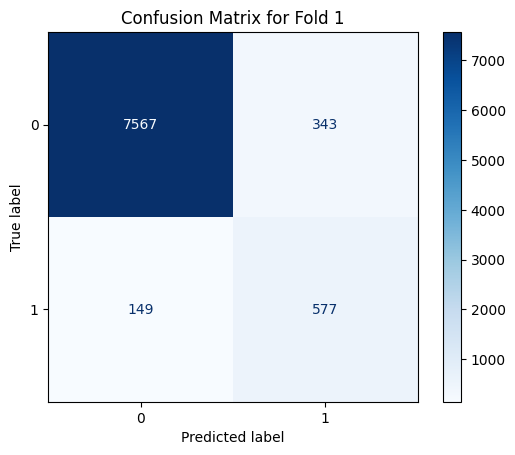

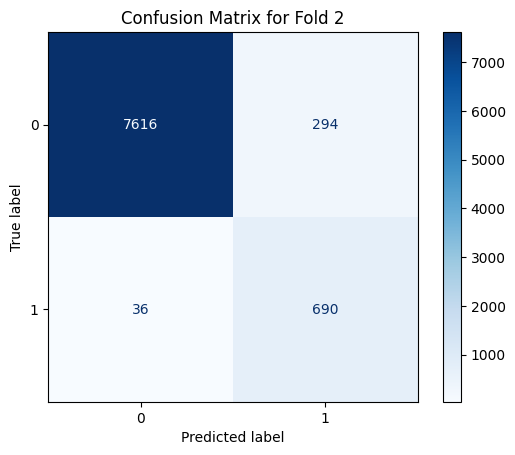

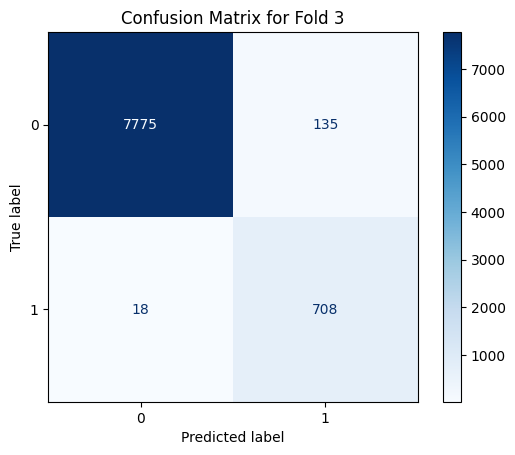

In [20]:
loss_type = config["loss_function"]["type"]

if loss_type == "FocalLoss":
    criterion = FocalLoss(
        alpha=config["loss_function"]["parameters"]["alpha"],
        gamma=config["loss_function"]["parameters"]["gamma"],
    )
elif loss_type == "BCEWithLogitsLoss":
    pos_weight = torch.tensor(config["loss_function"]["parameters"]["pos_weight"])
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    raise ValueError(f"Unknown loss function type: {loss_type}")

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = FocalLoss(alpha=2, gamma=3)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["optimizer"]["parameters"]["lr"],
    weight_decay=config["optimizer"]["parameters"]["weight_decay"],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Обучение модели
def train_model(model, data, orig_targets, criterion, optimizer, num_epochs=10, patience=10):
    for fold, (train_idx, val_idx) in enumerate(skf.split(data, orig_targets)):
        print(f'FOLD {fold+1}')
        print('-' * 30)

        # Разделяем данные на обучающую и валидационную выборки
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Расчёт весов для классов
        train_labels = [int(orig_targets[i]) for i in train_idx]
        class_counts = np.bincount(train_labels)
        class_weights = 1.0 / class_counts
        sample_weights = [class_weights[label] for label in train_labels]

        # Самплер
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Инициализация модели, оптимизатора и функции потерь
        model = model.to(device)
        criterion = criterion.to(device)
        # Обучение модели
        best_val_loss = float('inf')
        y_true, y_pred = [], []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            
            y_true = []
            y_pred = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = F.one_hot(labels, num_classes=2).float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

            # Валидация
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    labels = F.one_hot(labels, num_classes=2).float()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    # Подсчёт точности
                    _, preds = torch.max(outputs, 1)
                    _, labels = torch.max(labels, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            val_accuracy = correct / total
            recall = recall_score(y_true, y_pred)
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            
            print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_accuracy:.4f},  Precision: {precision:.4f},  Recall: {recall:.4f}")
            task.get_logger().report_scalar(title=f"Loss by fold {fold + 1}", series="Validation Loss", iteration=epoch, value=val_loss)
            task.get_logger().report_scalar(title=f"Accuracy by Fold {fold + 1}", series="Validation Accuracy", iteration=epoch, value=val_accuracy)
            task.get_logger().report_scalar(title=f"Precision by Fold {fold + 1}", series="Validation Precision", iteration=epoch, value=precision)
            task.get_logger().report_scalar(title=f"Recall by Fold {fold + 1}", series="Validation Recall", iteration=epoch, value=recall)

            # Сохраняем лучшую модель для текущего фолда
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

        # Логгирование результатов в ClearML
        task.get_logger().report_scalar(title=f"Loss by Folds", series="Validation Loss", iteration=fold, value=val_loss)
        task.get_logger().report_scalar(title=f"Accuracy by Folds", series="Validation Accuracy", iteration=fold, value=val_accuracy)
        task.get_logger().report_scalar(title=f"Precision by Folds", series="Validation Precision", iteration=fold, value=precision)
        task.get_logger().report_scalar(title=f"Recall by Folds", series="Validation Recall", iteration=fold, value=recall)

        # Матрица неточности
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for Fold {fold+1}")
        plt.savefig(f"confusion_matrix_fold_{fold+1}.png")
        task.get_logger().report_image(title=f"Fold {fold+1}", series="Confusion Matrix", local_path=f"confusion_matrix_fold_{fold+1}.png")

        # Сохраняем результаты фолда
        fold_results.append((best_val_loss, val_accuracy))
        print(f"Fold {fold+1} completed. Best Validation Loss: {best_val_loss:.4f}, Accuracy: {val_accuracy:.4f}\n")

# Итоговая статистика по всем фолдам
avg_loss = np.mean([result[0] for result in fold_results])
avg_accuracy = np.mean([result[1] for result in fold_results])
print(f"Cross-Validation Results: Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

task.get_logger().report_scalar(title="Overall", series="Average Validation Loss", iteration=0, value=avg_loss)
task.get_logger().report_scalar(title="Overall", series="Average Validation Accuracy", iteration=0, value=avg_accuracy)


# Запуск обучения
train_model(model, X_train, Y_train, criterion, optimizer, num_epochs=30)

In [21]:
# Сохранение модели
torch.save(model.state_dict(), "model_weights.pth")
task.upload_artifact(name="Model Weights", artifact_object="model_weights.pth")

# Сохранение конфигурации
task.upload_artifact(name="Config File", artifact_object="config.yaml")

2024-12-10 12:43:38,252 - clearml.frameworks - INFO - Found existing registered model id=565d52b1c2d64a4bb2044e7dbf33bde4 [/home/kravchenko.artem/Projects/Diplomas/Classifiers/Cross Valid NN/model_weights.pth] reusing it.


True

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning:

overflow encountered in reduce



Validation recall: 0.6465
Validation accuracy: 0.9217
Validation precision: 0.5292

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      5931
           1       0.53      0.65      0.58       546

    accuracy                           0.92      6477
   macro avg       0.75      0.80      0.77      6477
weighted avg       0.93      0.92      0.93      6477

Матрица несоответствий для тестовой выборки метода ЛДА:



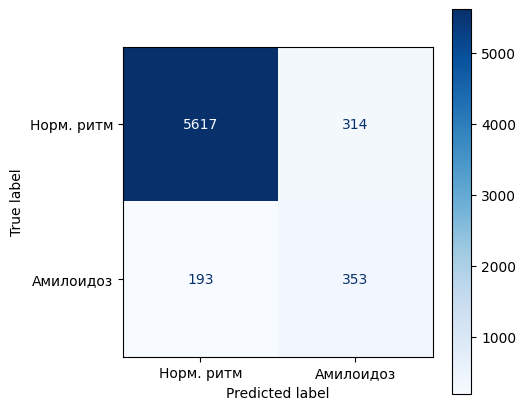

In [22]:
test_dataset = ECGDataset(data=X_test, labels=Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def validate_model(model, dataloader):
    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    # all_labels = np.argmax(all_labels, axis=1)

    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f"Validation recall: {recall:.4f}")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    precision = precision_score(all_labels, all_preds)
    print(f"Validation precision: {precision:.4f}")

    class_names = ["Норм. ритм", "Амилоидоз"]

    print("\n clasification report:\n", classification_report(all_labels, all_preds))

    print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(all_labels, all_preds), display_labels=class_names
    )
    disp.plot(cmap="Blues", ax=ax)

    Logger.current_logger().report_confusion_matrix(
        title="Confusion Matrix",
        series="Validation Results",
        matrix=confusion_matrix(all_labels, all_preds),
        yaxis_reversed=True,
        xaxis="Predicted",
        yaxis="Expected",
        xlabels=class_names,
        ylabels=class_names,
    )

    return recall


# Пример вызова валидации
test_accuracy = validate_model(model, test_loader)

In [23]:
mlflow.end_run()
task.close()